In [1]:
import datetime as dt
import polars as pl

from model import XGBoostModel
from config import get_config

In [2]:
target_col = 'fperf'
date_col = 'tdq'

In [3]:
def find_last_trading_date():
    """
    Find last trading date, which will be used for stock selection.

    Returns
    -------
    dt.datime
        Trading date.
    """

    today = dt.datetime.today()
    trade_dates = [
        dt.datetime(today.year, 3, 1),
        dt.datetime(today.year, 6, 1),
        dt.datetime(today.year, 9, 1),
        dt.datetime(today.year, 12, 1),
    ]
    past_dates = [date for date in trade_dates if date <= today]

    if past_dates:
        return max(past_dates)
    else:
        return None

last_trade_date = find_last_trading_date()
last_trade_date

datetime.datetime(2024, 9, 1, 0, 0)

In [4]:
data = pl.read_csv("../data/1_work_data/processed/proc_2024-10-20.csv", try_parse_dates=True)
data.head()

datadate,rdq,tdq,tic,sector_Communication Services,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,sector_Financials,sector_Health Care,sector_Industrials,sector_Information Technology,sector_Materials,sector_Real Estate,sector_Utilities,n_purch,n_sales,insider_balance,price_mom,price_qoq,price_yoy,price_2y,rsi_14d,rsi_30d,rsi_60d,rsi_90d,rsi_1y,vol_mom,vol_qoq,vol_yoy,rel_vol_mom,rel_vol_qoq,rel_vol_yoy,momentum_mom,momentum_qoq,momentum_yoy,momentum_2y,…,size,pe,pb,ps,ev_ebitda,saleq_yoy,saleq_2y,ni_yoy,ni_2y,ltq_qoq,ltq_yoy,ltq_2y,dlttq_yoy,gpm_qoq,gpm_yoy,roa_qoq,roa_yoy,roe_qoq,roe_yoy,fcf_yoy,cr_yoy,qr_yoy,der_yoy,dr_yoy,ltda_yoy,ev_eb_yoy,ltcr_yoy,pe_qoq,pe_yoy,pb_qoq,pb_yoy,ps_qoq,ps_yoy,freturn,adj_freturn,fperf,adj_fperf
date,date,date,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
2007-01-31,2007-02-15,2007-03-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,1,8.598,-0.0175,-0.018727,-0.126667,0.31,37.080402,42.592688,46.374228,46.439982,50.571208,0.014809,0.012043,0.01791,1.68021,1.931065,2.790708,0.974836,-7.1022,-1.324112,1.869599,…,8.880864,14.209289,2.490608,1.790829,14.053467,0.096829,0.056106,-0.946733,0.456311,-0.0469,-0.080125,0.045535,0.0,-0.011905,0.034773,-0.799034,-0.786032,-0.806646,-0.758874,1.314607,-0.033049,-0.06119,0.051933,0.026403,0.115807,-0.424184,1.314607,4.036292,2.825606,-0.023275,-0.077548,-0.045498,-0.192082,-2.63992,2.529805,0,0
2007-04-30,2007-05-14,2007-06-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,3,2.695,0.052226,0.241648,0.097162,0.594336,62.343397,62.077772,58.732066,58.636249,53.754651,0.016561,0.013553,0.017389,2.953679,2.207784,2.674983,1.932873,2.392662,0.463493,2.053564,…,8.893298,16.705873,3.04982,2.098338,15.689363,0.065375,0.032864,0.069565,0.294737,0.054299,-0.064022,0.096793,0.0,0.022113,0.058001,0.018496,-0.764364,0.041531,-0.756945,0.078838,-0.048932,-0.09261,0.072623,0.035449,0.106275,-0.275697,0.078838,0.175701,3.789035,0.224528,0.163999,0.171713,-0.006303,-2.324966,6.524635,0,0
2007-07-31,2007-08-14,2007-09-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,2,5.747,-0.057483,-0.051342,0.1375,0.13679,52.575103,48.65697,49.886609,49.92594,51.861727,0.032772,0.021062,0.01607,2.055281,1.725055,2.02726,-47.276502,1.795475,1.064454,0.622403,…,8.857088,16.580932,3.061018,1.89827,14.783464,0.108959,0.10628,-0.185022,0.778846,0.002146,-0.051054,0.097532,0.0,-0.00112,-0.005011,-0.053667,-0.789586,0.011234,-0.780068,27.0,-0.13529,-0.202801,0.094405,0.044192,0.10037,-0.142223,27.0,-0.007479,4.723257,0.003671,0.258728,-0.095346,0.039965,-4.505484,8.463398,0,0
2007-10-31,2007-11-15,2007-12-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,2,2.75,0.026594,0.046184,0.180712,0.065934,59.704889,54.609299,52.512775,52.488568,52.118787,0.026217,0.017897,0.016334,1.572782,1.465377,1.689781,-0.603821,7.683146,3.097014,0.3707,…,8.929833,15.693153,3.095928,1.847275,14.923904,0.088855,0.027719,0.208054,6.2,0.156317,0.16442,0.638847,0.391333,-0.021673,-0.01305,0.031532,-0.800194,0.068621,-0.782379,-0.057743,-0.142226,-0.198205,0.313484,0.135903,0.357259,-0.051532,-0.322767,-0.053542,4.562228,0.011405,0.214109,-0.026864,-0.015412,-54.374822,-9.4817,0,0
2008-01-31,2008-02-13,2008-03-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,2,3.418,-0.104447,-0.190854,-0.026399,-0.149722,34.6395,38.84194,42.496746,42.578853,48.452257,0.018267,0.018484,0.017808,1.373549,1.408677,1.586141,5.62391,1.878156,0.510655,-3.837171,…,8.917177,13.252579,2.539416,1.456275,10.717445,0.088281,0.193659,-0.2,-0.957386,-0.00787,0.212104,0.114984,-0.582667,0.010698,0.009526,-0.074634,-0.079976,-0.028701,0.093202,-1.535714,-0.306119,-0.280077,0.396995,0.168878,-0.597549,-0.237381,-2.28366,-0.155518,-0.06733,-0.179756,0.019597,-0.211663,-0.186815,-54.688005,-9.931763,0,0


In [5]:
features = get_config('model')['features']
df = data.select(
    [pl.col("fperf")] + [pl.col(ratio) for ratio in features]
).to_pandas()

df_standardized = (
    (df[features] - df[features] .mean()) /
    df[features].std()
)

corr = df_standardized.corrwith(df["fperf"])
corr

n_purch            0.028011
n_sales           -0.022153
insider_balance   -0.007744
price_mom         -0.025879
price_qoq         -0.016179
                     ...   
pe_yoy            -0.005563
pb_qoq            -0.004797
pb_yoy            -0.006125
ps_qoq            -0.000067
ps_yoy            -0.011832
Length: 71, dtype: float64

In [6]:
data = data.filter((pl.col('tdq') < last_trade_date))
data = data.filter(~pl.all_horizontal(pl.col(target_col).is_null()))

# filter cols
aux_cols = ['datadate', 'rdq', 'sector'] + [t for t in get_config('model')['targets'] if t != target_col]
data = data.select([c for c in data.columns if c not in aux_cols])
data.head()

tdq,tic,sector_Communication Services,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,sector_Financials,sector_Health Care,sector_Industrials,sector_Information Technology,sector_Materials,sector_Real Estate,sector_Utilities,n_purch,n_sales,insider_balance,price_mom,price_qoq,price_yoy,price_2y,rsi_14d,rsi_30d,rsi_60d,rsi_90d,rsi_1y,vol_mom,vol_qoq,vol_yoy,rel_vol_mom,rel_vol_qoq,rel_vol_yoy,momentum_mom,momentum_qoq,momentum_yoy,momentum_2y,gpm,roa,…,rtr,atr,cfm,size,pe,pb,ps,ev_ebitda,saleq_yoy,saleq_2y,ni_yoy,ni_2y,ltq_qoq,ltq_yoy,ltq_2y,dlttq_yoy,gpm_qoq,gpm_yoy,roa_qoq,roa_yoy,roe_qoq,roe_yoy,fcf_yoy,cr_yoy,qr_yoy,der_yoy,dr_yoy,ltda_yoy,ev_eb_yoy,ltcr_yoy,pe_qoq,pe_yoy,pb_qoq,pb_yoy,ps_qoq,ps_yoy,fperf
date,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
2007-03-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,1,8.598,-0.0175,-0.018727,-0.126667,0.31,37.080402,42.592688,46.374228,46.439982,50.571208,0.014809,0.012043,0.01791,1.68021,1.931065,2.790708,0.974836,-7.1022,-1.324112,1.869599,0.578125,0.088037,…,1.87821,0.1758,0.072656,8.880864,14.209289,2.490608,1.790829,14.053467,0.096829,0.056106,-0.946733,0.456311,-0.0469,-0.080125,0.045535,0.0,-0.011905,0.034773,-0.799034,-0.786032,-0.806646,-0.758874,1.314607,-0.033049,-0.06119,0.051933,0.026403,0.115807,-0.424184,1.314607,4.036292,2.825606,-0.023275,-0.077548,-0.045498,-0.192082,0
2007-06-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,3,2.695,0.052226,0.241648,0.097162,0.594336,62.343397,62.077772,58.732066,58.636249,53.754651,0.016561,0.013553,0.017389,2.953679,2.207784,2.674983,1.932873,2.392662,0.463493,2.053564,0.590909,0.089666,…,1.900648,0.182371,0.228788,8.893298,16.705873,3.04982,2.098338,15.689363,0.065375,0.032864,0.069565,0.294737,0.054299,-0.064022,0.096793,0.0,0.022113,0.058001,0.018496,-0.764364,0.041531,-0.756945,0.078838,-0.048932,-0.09261,0.072623,0.035449,0.106275,-0.275697,0.078838,0.175701,3.789035,0.224528,0.163999,0.171713,-0.006303,0
2007-09-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,2,5.747,-0.057483,-0.051342,0.1375,0.13679,52.575103,48.65697,49.886609,49.92594,51.861727,0.032772,0.021062,0.01607,2.055281,1.725055,2.02726,-47.276502,1.795475,1.064454,0.622403,0.590247,0.084854,…,1.887363,0.192074,0.128093,8.857088,16.580932,3.061018,1.89827,14.783464,0.108959,0.10628,-0.185022,0.778846,0.002146,-0.051054,0.097532,0.0,-0.00112,-0.005011,-0.053667,-0.789586,0.011234,-0.780068,27.0,-0.13529,-0.202801,0.094405,0.044192,0.10037,-0.142223,27.0,-0.007479,4.723257,0.003671,0.258728,-0.095346,0.039965,0
2007-12-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,2,2.75,0.026594,0.046184,0.180712,0.065934,59.704889,54.609299,52.512775,52.488568,52.118787,0.026217,0.017897,0.016334,1.572782,1.465377,1.689781,-0.603821,7.683146,3.097014,0.3707,0.577455,0.087529,…,1.96334,0.198381,0.275242,8.929833,15.693153,3.095928,1.847275,14.923904,0.088855,0.027719,0.208054,6.2,0.156317,0.16442,0.638847,0.391333,-0.021673,-0.01305,0.031532,-0.800194,0.068621,-0.782379,-0.057743,-0.142226,-0.198205,0.313484,0.135903,0.357259,-0.051532,-0.322767,-0.053542,4.562228,0.011405,0.214109,-0.026864,-0.015412,0
2008-03-01,"""A""",0,0,0,0,0,1,0,0,0,0,0,0,2,3.418,-0.104447,-0.190854,-0.026399,-0.149722,34.6395,38.84194,42.496746,42.578853,48.452257,0.018267,0.018484,0.017808,1.373549,1.408677,1.586141,5.62391,1.878156,0.510655,-3.837171,0.583632,0.080996,…,1.906913,0.185573,0.002872,8.917177,13.252579,2.539416,1.456275,10.717445,0.088281,0.193659,-0.2,-0.957386,-0.00787,0.212104,0.114984,-0.582667,0.010698,0.009526,-0.074634,-0.079976,-0.028701,0.093202,-1.535714,-0.306119,-0.280077,0.396995,0.168878,-0.597549,-0.237381,-2.28366,-0.155518,-0.06733,-0.179756,0.019597,-0.211663,-0.186815,0


In [7]:
train = data.filter(
    (pl.col('tdq').dt.year() > 2007) &
    (pl.col('tdq').dt.year() < 2020)
)
val = data.filter(
    (pl.col('tdq').dt.year() >= 2021) &
    (pl.col('tdq').dt.year() < 2023)
)

def get_scale():
    scale = round(
        len(train.filter(pl.col(target_col) == 0)) /
        len(train.filter(pl.col(target_col) == 1))
    )

    print(f"Scale of training data (pos/neg): {scale}")
    return scale

scale = get_scale()

X_train = train.select(pl.exclude(['tic', target_col, date_col])).to_pandas()
y_train = train.select(target_col).to_pandas().values.ravel()
X_val = val.select(pl.exclude(['tic', target_col, date_col])).to_pandas()
y_val = val.select(target_col).to_pandas().values.ravel()

X_train

Scale of training data (pos/neg): 4


,sector_Communication Services,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,sector_Financials,sector_Health Care,sector_Industrials,sector_Information Technology,sector_Materials,sector_Real Estate,...,dr_yoy,ltda_yoy,ev_eb_yoy,ltcr_yoy,pe_qoq,pe_yoy,pb_qoq,pb_yoy,ps_qoq,ps_yoy
0,0,0,0,0,0,1,0,0,0,0,...,0.168878,-0.597549,-0.237381,-2.283660,-0.155518,-0.067330,-0.179756,0.019597,-0.211663,-0.186815
1,0,0,0,0,0,1,0,0,0,0,...,0.150162,-0.606461,-0.243443,1.671284,0.104472,-0.123835,0.201739,0.000622,0.166625,-0.190346
2,0,0,0,0,0,1,0,0,0,0,...,0.086017,-0.624940,-0.296361,1.306055,-0.053963,-0.164869,-0.085371,-0.088150,-0.088225,-0.183973
3,0,0,0,0,0,1,0,0,0,0,...,0.146931,0.034227,-0.492541,-0.414559,-0.549697,-0.602664,-0.395018,-0.454568,-0.516872,-0.594871
4,0,0,0,0,0,1,0,0,0,0,...,0.115582,2.583585,-0.339152,0.835314,-0.137612,-0.594239,-0.211000,-0.475344,-0.174860,-0.575958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28455,0,0,0,0,0,1,0,0,0,0,...,0.019003,0.155060,0.027490,-0.036780,-0.010984,0.031133,-0.033817,0.221064,0.008477,0.147269
28456,0,0,0,0,0,1,0,0,0,0,...,0.006650,0.036365,0.049981,-0.261604,-0.166670,-0.288948,-0.009015,-0.039392,0.004080,0.070703
28457,0,0,0,0,0,1,0,0,0,0,...,0.018599,0.038653,0.084162,-0.231223,0.077297,-0.177863,-0.012534,-0.005428,0.031362,0.073674
28458,0,0,0,0,0,1,0,0,0,0,...,0.014194,0.018725,0.285852,-0.084477,0.260801,0.119444,0.200296,0.134845,0.221723,0.275905


In [8]:
len(train.filter(pl.col(target_col) == 0)) / len(train.filter(pl.col(target_col) == 1))

3.851687691783157

In [9]:
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
import sklearn.metrics as skm

params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'n_estimators': 200,
    'max_depth': 3,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 1,
    'colsample_bytree': 1,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'scale_pos_weight': scale,
    'eval_metric': 'logloss',
    'nthread': -1,
    'seed': get_config('model')['seed']
}

# Train XGBoost model
rbf_model = XGBClassifier(**params)

# Use RFE to rank feature importance and eliminate unuseful features
selector = RFE(rbf_model, n_features_to_select=60)  # choose the number of features to keep
selector = selector.fit(X_train, y_train)

# Get support mask and ranking
support = selector.support_
ranking = selector.ranking_

rbf_model.fit(X_train, y_train)
init_probs = rbf_model.predict_proba(X_val)[:, 1]
print("Model roc-auc with initial features:", skm.roc_auc_score(y_val, init_probs))
print("Model pr-auc with initial features:", skm.average_precision_score(y_val, init_probs))

# See which features were kept
selected_features = X_train.columns[support]
print("Selected Features:", selected_features)

# Retrain model using only selected features
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
rbf_model.fit(X_train_selected, y_train)

sel_probs = rbf_model.predict_proba(X_val_selected)[:, 1]
print("Model roc-auc with selected features:", skm.roc_auc_score(y_val, sel_probs))
print("Model pr-auc with selected features:", skm.average_precision_score(y_val, sel_probs))

Model roc-auc with initial features: 0.6899804288279641
Model pr-auc with initial features: 0.20956971001588387
Selected Features: Index(['sector_Communication Services', 'sector_Energy', 'sector_Financials',
       'sector_Information Technology', 'sector_Materials', 'sector_Utilities',
       'price_mom', 'price_qoq', 'price_yoy', 'price_2y', 'rsi_14d', 'rsi_30d',
       'rsi_60d', 'rsi_90d', 'vol_mom', 'vol_qoq', 'vol_yoy', 'rel_vol_mom',
       'rel_vol_qoq', 'rel_vol_yoy', 'momentum_mom', 'momentum_qoq',
       'momentum_yoy', 'momentum_2y', 'gpm', 'roa', 'roe', 'ebitdam', 'cr',
       'qr', 'csr', 'dr', 'der', 'debitda', 'ltda', 'ltcr', 'itr', 'rtr',
       'atr', 'cfm', 'size', 'pe', 'pb', 'ps', 'ev_ebitda', 'saleq_yoy',
       'saleq_2y', 'ltq_yoy', 'ltq_2y', 'dlttq_yoy', 'roa_qoq', 'roa_yoy',
       'cr_yoy', 'qr_yoy', 'dr_yoy', 'ltda_yoy', 'ev_eb_yoy', 'pb_qoq',
       'pb_yoy', 'ps_yoy'],
      dtype='object')
Model roc-auc with selected features: 0.6915442606400145
Model pr

In [10]:
model = XGBoostModel(scale=scale)
model.train(X_train_selected, y_train)
model.evaluate(X_val_selected, y_val)['roc_auc']

0.7110512988141442

In [11]:
model.evaluate(X_val_selected, y_val)['prec']

0.25766871165644173

In [12]:
# pr auc analysis
baseline = float(
    len(val.filter(pl.col(target_col) == 1)) /
    len(val)
)

pr_auc = model.evaluate(X_val_selected, y_val)['pr_auc']
pr_auc

print(f"Baseline {baseline}, PR-AUC = {pr_auc}")

Baseline 0.11703887510339123, PR-AUC = 0.2171200024648707


In [13]:
model.get_importance("gain")

[('vol_yoy', 857.3648681640625),
 ('vol_qoq', 344.6225280761719),
 ('vol_mom', 213.6708526611328),
 ('size', 205.47373962402344),
 ('price_2y', 193.14451599121094),
 ('csr', 177.49891662597656),
 ('atr', 143.329345703125),
 ('price_mom', 142.10800170898438),
 ('sector_Utilities', 137.2643280029297),
 ('rel_vol_qoq', 136.53379821777344),
 ('rsi_90d', 136.39456176757812),
 ('ltq_2y', 131.46121215820312),
 ('ps', 129.3538818359375),
 ('sector_Energy', 107.64088439941406),
 ('price_yoy', 105.4832992553711),
 ('momentum_2y', 93.20005798339844),
 ('rel_vol_yoy', 90.47054290771484),
 ('pb_qoq', 90.3153076171875),
 ('sector_Financials', 90.23635864257812),
 ('pb', 90.19242095947266),
 ('ltq_yoy', 86.10736083984375),
 ('momentum_yoy', 85.1613998413086),
 ('sector_Information Technology', 82.3709716796875),
 ('cr_yoy', 81.35244750976562),
 ('momentum_mom', 79.62733459472656),
 ('price_qoq', 79.00870513916016),
 ('cr', 74.95240020751953),
 ('dr', 69.02603912353516),
 ('saleq_2y', 67.9234924316406

In [14]:
model.get_importance("weight")

[('vol_yoy', 30.0),
 ('size', 29.0),
 ('momentum_2y', 23.0),
 ('price_mom', 19.0),
 ('csr', 15.0),
 ('momentum_yoy', 14.0),
 ('ps', 14.0),
 ('gpm', 13.0),
 ('rel_vol_qoq', 12.0),
 ('rel_vol_yoy', 11.0),
 ('momentum_mom', 11.0),
 ('atr', 11.0),
 ('price_2y', 10.0),
 ('pb', 10.0),
 ('sector_Utilities', 9.0),
 ('momentum_qoq', 9.0),
 ('vol_qoq', 8.0),
 ('dr', 8.0),
 ('vol_mom', 6.0),
 ('roe', 6.0),
 ('cr', 6.0),
 ('price_yoy', 4.0),
 ('rsi_60d', 4.0),
 ('rel_vol_mom', 4.0),
 ('ebitdam', 4.0),
 ('ltcr', 4.0),
 ('itr', 4.0),
 ('rtr', 4.0),
 ('ev_eb_yoy', 4.0),
 ('roa', 3.0),
 ('pe', 3.0),
 ('qr_yoy', 3.0),
 ('sector_Information Technology', 2.0),
 ('price_qoq', 2.0),
 ('rsi_14d', 2.0),
 ('rsi_90d', 2.0),
 ('qr', 2.0),
 ('ev_ebitda', 2.0),
 ('saleq_yoy', 2.0),
 ('cr_yoy', 2.0),
 ('dr_yoy', 2.0),
 ('ltda_yoy', 2.0),
 ('pb_yoy', 2.0),
 ('sector_Communication Services', 1.0),
 ('sector_Energy', 1.0),
 ('sector_Financials', 1.0),
 ('debitda', 1.0),
 ('cfm', 1.0),
 ('saleq_2y', 1.0),
 ('ltq_yoy',

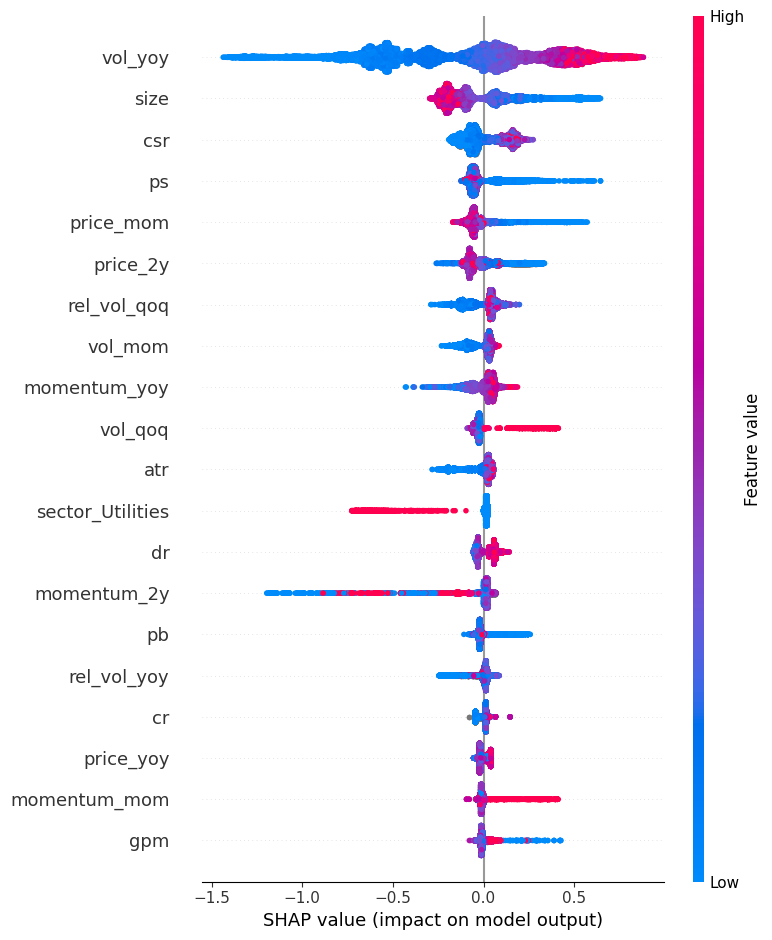

In [15]:
import shap

explainer = shap.TreeExplainer(model.model)
shap_values = explainer.shap_values(X_train_selected)
shap.summary_plot(shap_values, X_train_selected, max_display=20)

In [16]:
import numpy as np
import pandas as pd

# Get mean absolute SHAP values per feature
shap_abs = pl.DataFrame({
    'Feature': X_train.columns,
    'Mean SHAP Value': np.mean(np.abs(shap_values), axis=0)
}).sort('Mean SHAP Value', descending=False)

print(shap_abs)

ShapeError: could not create a new DataFrame: series 82 has length 82 while series "Mean SHAP Value" has length 60